In [24]:
! pip install google-cloud-bigquery-storage | grep -v 'already satisfied'
! pip install pyarrow | grep -v 'already satisfied'
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplcursors

# Project 1: Lyft Bike Data Analysis

### The goal of this project is to use data from Google BigQuery to provide 5 examples of commuter bike trips and give some operations recommendations based on the data. 

# Plot 1: Rush Hour 

#### To find our commuter trips, we first should ask,"Which day of the week do most trips occur? In addition, during rush hour times which stations see the most traffic?" The following queries answer this. 

Question: Which days of the week have the most trips?

In [25]:
%%bigquery day_of_week
SELECT *,
       EXTRACT(DAYOFWEEK FROM start_date) AS dow_int,
       CASE EXTRACT(DAYOFWEEK FROM start_date)
           WHEN 1 THEN "Sunday"
           WHEN 2 THEN "Monday"
           WHEN 3 THEN "Tuesday"
           WHEN 4 THEN "Wednesday"
           WHEN 5 THEN "Thursday"
           WHEN 6 THEN "Friday"
           WHEN 7 THEN "Saturday"
           END AS dow_str,
       CASE 
           WHEN EXTRACT(DAYOFWEEK FROM start_date) IN (1, 7) THEN "Weekend"
           ELSE "Weekday"
           END AS dow_weekday,
       EXTRACT(HOUR FROM start_date) AS start_hour,
       CASE 
           WHEN EXTRACT(HOUR FROM start_date) <= 5  OR EXTRACT(HOUR FROM start_date) >= 23 THEN "Nightime"
           WHEN EXTRACT(HOUR FROM start_date) >= 6 and EXTRACT(HOUR FROM start_date) <= 8 THEN "Morning"
           WHEN EXTRACT(HOUR FROM start_date) >= 9 and EXTRACT(HOUR FROM start_date) <= 10 THEN "Mid Morning"
           WHEN EXTRACT(HOUR FROM start_date) >= 11 and EXTRACT(HOUR FROM start_date) <= 13 THEN "Mid Day"
           WHEN EXTRACT(HOUR FROM start_date) >= 14 and EXTRACT(HOUR FROM start_date) <= 16 THEN "Early Afternoon"
           WHEN EXTRACT(HOUR FROM start_date) >= 17 and EXTRACT(HOUR FROM start_date) <= 19 THEN "Afternoon"
           WHEN EXTRACT(HOUR FROM start_date) >= 20 and EXTRACT(HOUR FROM start_date) <= 22 THEN "Evening"
           END AS start_hour_str
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
ORDER BY start_date ASC


In [26]:
day_of_week.head()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type,dow_int,dow_str,dow_weekday,start_hour,start_hour_str
0,4069,174,2013-08-29 09:08:00+00:00,2nd at South Park,64,2013-08-29 09:11:00+00:00,2nd at South Park,64,288,94114,Subscriber,5,Thursday,Weekday,9,Mid Morning
1,4073,1067,2013-08-29 09:24:00+00:00,South Van Ness at Market,66,2013-08-29 09:42:00+00:00,San Francisco Caltrain 2 (330 Townsend),69,321,94703,Subscriber,5,Thursday,Weekday,9,Mid Morning
2,4075,1117,2013-08-29 09:24:00+00:00,South Van Ness at Market,66,2013-08-29 09:43:00+00:00,San Francisco Caltrain 2 (330 Townsend),69,316,94122,Subscriber,5,Thursday,Weekday,9,Mid Morning
3,4074,1131,2013-08-29 09:24:00+00:00,South Van Ness at Market,66,2013-08-29 09:43:00+00:00,San Francisco Caltrain 2 (330 Townsend),69,317,94115,Subscriber,5,Thursday,Weekday,9,Mid Morning
4,4076,1118,2013-08-29 09:25:00+00:00,South Van Ness at Market,66,2013-08-29 09:43:00+00:00,San Francisco Caltrain 2 (330 Townsend),69,322,94597,Subscriber,5,Thursday,Weekday,9,Mid Morning


In [27]:
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_counts = day_of_week.groupby("dow_str")["trip_id"].count().reindex(days)
day_of_week_counts

dow_str
Monday       169937
Tuesday      184405
Wednesday    180767
Thursday     176908
Friday       159977
Saturday      60279
Sunday        51375
Name: trip_id, dtype: int64

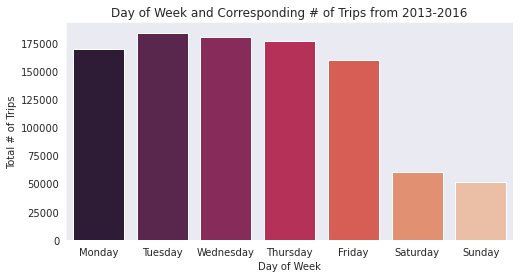

In [28]:
plt.figure(figsize=(8,4)) 
sns.barplot(x=day_of_week_counts.index,y=day_of_week_counts,palette="rocket")
plt.xlabel("Day of Week")
plt.ylabel("Total # of Trips")
plt.title("Day of Week and Corresponding # of Trips from 2013-2016");

#### We can see that the majority of trips occur on Tuesdays during the 4 year period. We should find out what times are most popular on that day. 

In [1]:
%%bigquery tuesday_sql
SELECT *
FROM `september2020.trips.day_of_week_included` 
WHERE dow_str = "Tuesday"

In [2]:
tuesday_sql.groupby("start_hour").count().sort_values("trip_id",ascending=False)["trip_id"].head(6).reindex([7,8,9,16,17,18])

start_hour
7     14497
8     28138
9     18873
16    16434
17    25458
18    17464
Name: trip_id, dtype: int64

#### It seems most people take trips from 7-9 AM and from 4-6PM. Let's see which stations these people are leaving from.

In [31]:
%%bigquery tuesday_rush_hour_stations
SELECT COUNT(start_station_name) as count,start_station_name 
FROM `september2020.trips.day_of_week_included` 
WHERE 
  start_hour IN (7,8,9,16,17,18) AND dow_str = "Tuesday"
GROUP BY start_station_name 
ORDER BY count DESC

In [32]:
tuesday_rush_hour_stations

,count,start_station_name
0,11105,San Francisco Caltrain (Townsend at 4th)
1,8981,San Francisco Caltrain 2 (330 Townsend)
2,6481,Temporary Transbay Terminal (Howard at Beale)
3,5774,Harry Bridges Plaza (Ferry Building)
4,5439,Steuart at Market
...,...,...
76,5,Middlefield Light Rail Station
77,4,Cyril Magnin St at Ellis St
78,3,S. Market St at Park Ave
79,3,Sequoia Hospital


#### The Caltrain stations get a lot of traffic! I wonder which other stations do as well... Let's take a look at a map!

In [33]:
%%bigquery tuesday_rush_hour_locations
SELECT stations.latitude as lat, stations.longitude as long,rush_hour.count as count,stations.name as name 
FROM `september2020.stations.stations` stations 
LEFT JOIN `september2020.stations.tuesday_rush_hour_stations` rush_hour 
ON (rush_hour.start_station_name = stations.name) 
ORDER BY count DESC LIMIT 20


In [34]:
tuesday_rush_hour_locations.head()

,lat,long,count,name
0,37.776617,-122.395260,11105,San Francisco Caltrain (Townsend at 4th)
1,37.776600,-122.395470,8981,San Francisco Caltrain 2 (330 Townsend)
2,37.789756,-122.394643,6481,Temporary Transbay Terminal (Howard at Beale)
3,37.795392,-122.394203,5774,Harry Bridges Plaza (Ferry Building)
4,37.794139,-122.394434,5439,Steuart at Market


In [35]:
tues_bounds= (-122.4308,-122.3660,37.7600,37.8080)
tues_bounds

(-122.4308, -122.366, 37.76, 37.808)

In [36]:
tues_region = plt.imread('/home/jupyter/w205/project-1-mbearw-berkeley/images/tuesday_map.png')

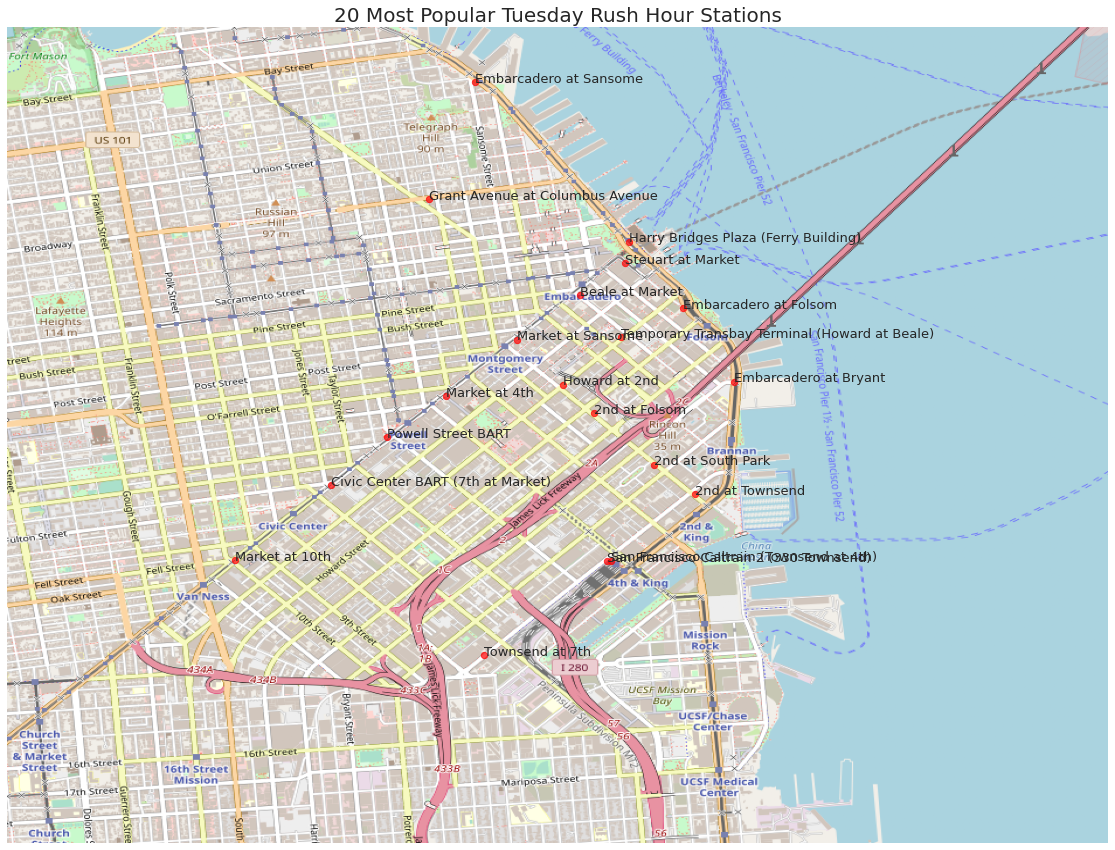

In [37]:
def plot_map(region,bounds,data,title,annotate=True):
    fig,ax = plt.subplots(figsize=(20,15))
    ax.scatter(data.long,data.lat,alpha=0.7,c="r",s=40)
    ax.set_title(title,fontsize=20)
    ax.set_xlim(bounds[0],bounds[1])
    ax.set_ylim(bounds[2],bounds[3])
    plt.axis('off')
    if annotate:
        for i, txt in enumerate(data.name):
            ax.annotate(txt, (data.long[i], data.lat[i]),clip_on=True,fontsize = 13)
    ax.imshow(region,extent=bounds);
    return

plot_map(tues_region,tues_bounds,tuesday_rush_hour_locations,"20 Most Popular Tuesday Rush Hour Stations")

* Note that the overlapping stations between 2nd at Townsend and Townsend at 7th are the Caltrain Stations. (They're very close together!)

### Notice a pattern? The stations along Embarcadero and the stations along Market Street are the 20 most popular stations on the most popular day. What decisions can be made from this?

### Recommendation 1: 
   #### If we want to place the burden of rising profits on the customers, we can charge a "Peak Pricing" rate on the bikes from 7-9AM and 4-6PM.
   * to encourage subscribers, we can try only applying this special rate to non subscribed users.

# Plot 2:

### Let's focus again on Tuesday, our high volume day. Besides the usual peaks during rush hour, maybe there's something else we missed.

#### First let's split by year

year_added table
```sql
SELECT EXTRACT(YEAR FROM (CAST(start_date AS DATE))) as year,*
FROM `september2020.trips.day_of_week_included` 
ORDER BY start_date
```

In [38]:
%%bigquery tuesday_hour_counts_by_year
SELECT start_hour,year,count(*) as count
FROM `september2020.trips.year_added`
WHERE dow_str = "Tuesday"
GROUP BY start_hour,year

In [39]:
tuesday_hour_counts_by_year.sort_values("year")

,start_hour,year,count
47,12,2013,989
26,8,2013,1967
31,20,2013,471
32,0,2013,39
33,14,2013,695
...,...,...,...
66,1,2016,13
65,19,2016,1747
6,15,2016,1629
80,4,2016,37


In [3]:
fig,axs = plt.subplots(4,1,figsize=(10,10))
fig.tight_layout(pad=3)
for ax,year in zip(axs,np.unique(tuesday_hour_counts_by_year.year)):
    sns.barplot(x="start_hour",y="count",data = tuesday_hour_counts_by_year[tuesday_hour_counts_by_year["year"]==year],ax=ax,palette="rocket")
    ax.set_xlabel("Hour")
    ax.set_ylim(0,10000)
    ax.set_ylabel("# of trips")
    ax.set_title("Tuesday Riding Hours for " + str(year))



NameError: name 'plt' is not defined

## Recommendation 2: 
   #### If we follow Recommendation 1, then having a discount from the hours of 10AM-3PM should increase rider volume during those hours. 
   * Again, we can apply the discount to subscribed users only to incentivize buying a subscription

# Plot 3

### Let's check out the least popular rides and see if we can try to boost those numbers!

#### It seems the weekend doesn't have much bike usage, only accounting for roughly 1/9th of total trips.

In [42]:
weekend_totals = day_of_week_counts.tail(2)
weekend_totals

dow_str
Saturday    60279
Sunday      51375
Name: trip_id, dtype: int64

In [43]:
"Weekends only have " + str(sum(weekend_totals)) + " total trips."

'Weekends account for only 111654 trips.'

#### What time do most weekend rides happen?

 We're taking a similar approach to the last plot.

In [44]:
%%bigquery weekend_hour_counts
SELECT count(start_hour) as count, start_hour
FROM `september2020.trips.day_of_week_included` 
WHERE dow_str = "Sunday" OR dow_str = "Saturday"
GROUP BY start_hour 
ORDER BY count DESC

In [45]:
weekend_hour_counts["count_percent"] = (weekend_hour_counts["count"]/sum(weekend_hour_counts["count"]))*100
weekend_hour_counts.head(10)

,count,start_hour,count_percent
0,10685,13,9.569742
1,10568,12,9.464954
2,10262,14,9.190893
3,10202,15,9.137156
4,9755,16,8.736812
5,9695,11,8.683074
6,7970,17,7.138123
7,7894,10,7.070056
8,6381,18,5.714977
9,5854,9,5.242983


In [46]:
sum(weekend_hour_counts.count_percent[:5])

46.09955756175327

The hours between Noon and 4 PM account for almost 50 percent of weekend riders. Where are these people riding?

#### Which stations should we examine? In order to maximize our overall rider numbers, we should look at the least popular stations. 
##### (Of course we'd need more data to see if there are other factors besides cost that make them unpopular) 

let's create Weekend_popular_stations_noon_to_four
```sql
SELECT COUNT(start_station_name) as count,start_station_name 
FROM `september2020.trips.day_of_week_included` 
WHERE 
  start_hour BETWEEN 12 AND 16 AND dow_str = "Sunday" or dow_str = "Saturday"
GROUP BY start_station_name 
ORDER BY count DESC
LIMIT 20
```

In [47]:
%%bigquery weekend_popular_locations
SELECT stations.latitude as lat, stations.longitude as long,weekends.count as count,stations.name as name 
FROM `september2020.stations.stations` stations
LEFT JOIN `september2020.stations.Weekend_popular_stations_noon_to_four` weekends
ON (weekends.start_station_name = stations.name) 
ORDER BY count LIMIT 20

In [48]:
weekend_popular_locations.fillna(0,inplace=True)
weekend_popular_locations.head(5)

,lat,long,count,name
0,37.332398,-121.890429,0.0,S. Market st at Park Ave
1,37.331957,-121.881630,0.0,5th S. at E. San Salvador St
2,37.487682,-122.223492,13.0,Redwood City Medical Center
3,37.785908,-122.408891,16.0,Cyril Magnin St at Ellis St
4,37.395337,-122.052476,18.0,Middlefield Light Rail Station


In [49]:
weekend_bounds = (weekend_popular_locations.long.min(),weekend_popular_locations.long.max(),
          weekend_popular_locations.lat.min(),weekend_popular_locations.lat.max())
weekend_bounds
rounded_weekend_bounds = (-122.41,-121.88,37.331,37.79)

In [50]:
weekend_region = plt.imread('/home/jupyter/w205/project-1-mbearw-berkeley/images/weekend_map.png')

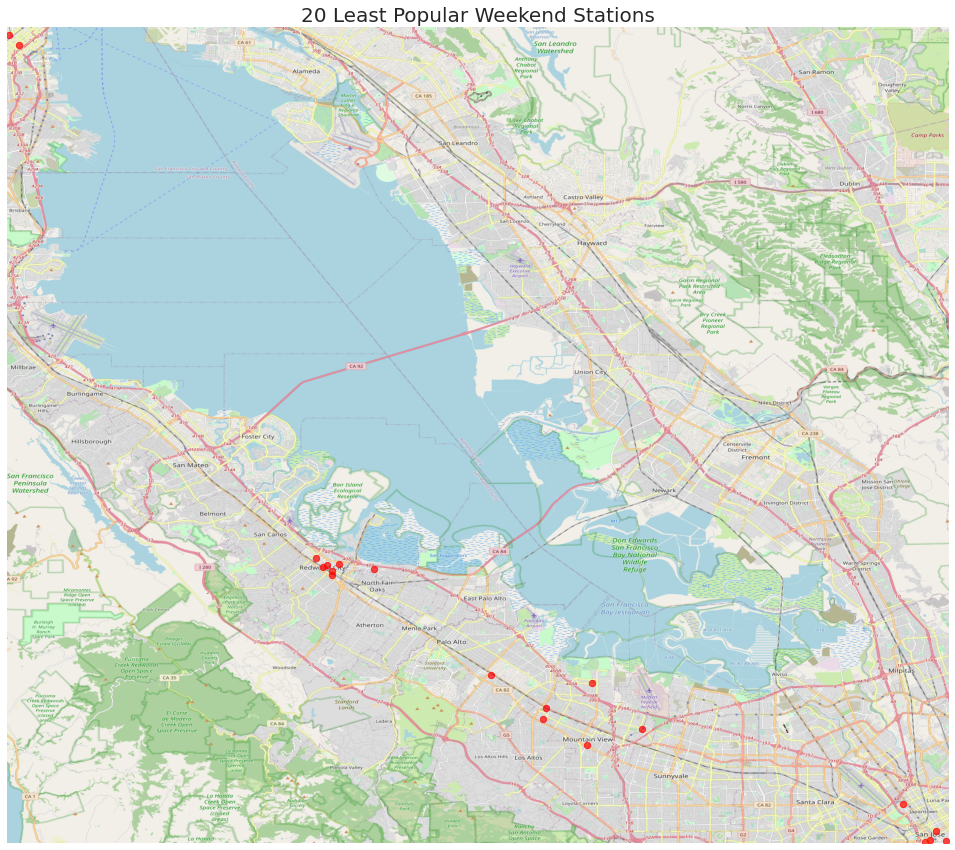

In [51]:
plot_map(weekend_region,rounded_weekend_bounds,weekend_popular_locations,"20 Least Popular Weekend Stations",annotate=False)

#### Many stations in Redwood City, Mountainview, and San Jose need some attention!

### Recommendation 3: 
   #### If we want to increase rider usage on weekends, we could offer a discount at these 20 least popular locations between the hours of 12 and 4PM.

# 5 Commuter Trips

### We have enough information now to decide which 5 rows in the dataset best represent a commuter ride.

Let's find them iteratively from the trips dataset

#### We've seen that Tuesday rides are the most common in the dataset.

In [52]:
tuesdays = day_of_week[day_of_week["dow_str"]=="Tuesday"]
print(tuesdays.shape)
tuesdays.head(3)

(184405, 16)


,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type,dow_int,dow_str,dow_weekday,start_hour,start_hour_str
3469,9368,615,2013-09-03 00:23:00+00:00,Powell at Post (Union Square),71,2013-09-03 00:34:00+00:00,Davis at Jackson,42,566,94111,Customer,3,Tuesday,Weekday,0,Nightime
3470,9369,157,2013-09-03 00:29:00+00:00,St James Park,13,2013-09-03 00:31:00+00:00,St James Park,13,34,95123,Customer,3,Tuesday,Weekday,0,Nightime
3471,9371,1244,2013-09-03 00:30:00+00:00,Market at Sansome,77,2013-09-03 00:51:00+00:00,South Van Ness at Market,66,428,,Customer,3,Tuesday,Weekday,0,Nightime


#### We also know that the starting times of 7-9AM and 4-6PM are most popular.

In [53]:
rush_hour_tuesdays = tuesdays[(tuesdays["start_hour"].between(7,9) | tuesdays["start_hour"].between(16,18))]
print(rush_hour_tuesdays.shape)
rush_hour_tuesdays.head(3)

(120864, 16)


,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type,dow_int,dow_str,dow_weekday,start_hour,start_hour_str
3485,9386,693,2013-09-03 07:03:00+00:00,San Francisco City Hall,58,2013-09-03 07:15:00+00:00,Post at Kearney,47,394,94117,Subscriber,3,Tuesday,Weekday,7,Morning
3486,9387,591,2013-09-03 07:08:00+00:00,Commercial at Montgomery,45,2013-09-03 07:18:00+00:00,San Francisco Caltrain (Townsend at 4th),70,575,2906,Customer,3,Tuesday,Weekday,7,Morning
3487,9388,853,2013-09-03 07:11:00+00:00,South Van Ness at Market,66,2013-09-03 07:25:00+00:00,Temporary Transbay Terminal (Howard at Beale),55,486,94103,Subscriber,3,Tuesday,Weekday,7,Morning


#### Over the 3 years, The San Francisco Caltrain (Townsend at 4th) station was the most popular. Most likely people getting off the train and making their "Last Mile" trek to the office. 

*tuesday_rush_hour_locations is from plot 1*

In [54]:
tuesday_rush_hour_locations.head(1)

,lat,long,count,name
0,37.776617,-122.39526,11105,San Francisco Caltrain (Townsend at 4th)


#### Combining all these factors produces these 5 rows as our commuter trips!

In [55]:
caltrain_rows = rush_hour_tuesdays[rush_hour_tuesdays["start_station_id"]==70]
caltrain_rows.head(5)

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type,dow_int,dow_str,dow_weekday,start_hour,start_hour_str
3503,9406,728,2013-09-03 07:48:00+00:00,San Francisco Caltrain (Townsend at 4th),70,2013-09-03 08:01:00+00:00,Market at Sansome,77,575,94010,Subscriber,3,Tuesday,Weekday,7,Morning
3511,9415,752,2013-09-03 08:04:00+00:00,San Francisco Caltrain (Townsend at 4th),70,2013-09-03 08:16:00+00:00,Harry Bridges Plaza (Ferry Building),50,541,94002,Subscriber,3,Tuesday,Weekday,8,Morning
3525,9431,498,2013-09-03 08:26:00+00:00,San Francisco Caltrain (Townsend at 4th),70,2013-09-03 08:34:00+00:00,Embarcadero at Bryant,54,406,94040,Subscriber,3,Tuesday,Weekday,8,Morning
3526,9432,583,2013-09-03 08:27:00+00:00,San Francisco Caltrain (Townsend at 4th),70,2013-09-03 08:37:00+00:00,Howard at 2nd,63,539,94025,Subscriber,3,Tuesday,Weekday,8,Morning
3529,9433,608,2013-09-03 08:30:00+00:00,San Francisco Caltrain (Townsend at 4th),70,2013-09-03 08:40:00+00:00,Temporary Transbay Terminal (Howard at Beale),55,435,94002,Customer,3,Tuesday,Weekday,8,Morning
